# Blog Post: Perceptron
In this blog post, I will explore the perceptron algorithm, one of the oldest classification algorithms. First, I will implement the perceptron algorithm, and then I will conduct a couple of experiments to ensure that it is working properly. The first experiment will confirm that the algorithm will converge to a loss of 0 on linearly separable data. The next experiment will show that given non-linearly separable data, the algorithm will continue iterating until it reaches a maximum number of iterations without ever converging. The final experiment will demonstrate that the perceptron can work in more than 2 dimensions. After that, I will implement minibatch perceptron. Before concluding, I will summarize my findings. 

In [3]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from perceptron_mini import PerceptronMini, PerceptronOptimizerMini

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
from matplotlib import pyplot as plt

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, w, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

X, y = perceptron_data()

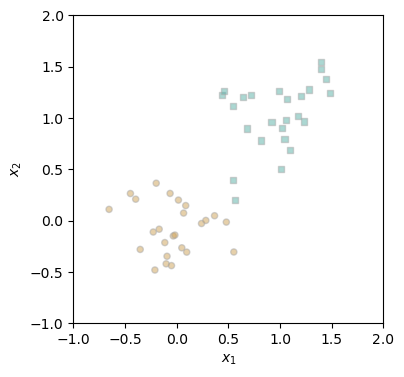

In [5]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, [0, 0, 0], ax)

### Experiment 1
In this experiment, I will show that given linearly separable data, the perceptron algorithm will converge to a value of w that separates the data.

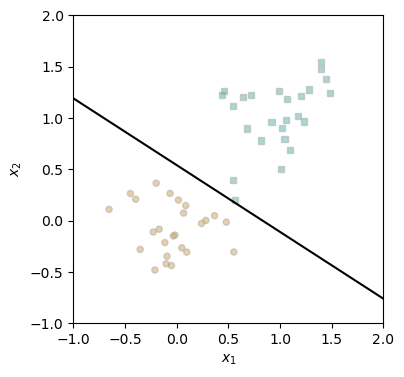

In [6]:
# instantiate a model and an optimizer
p = Perceptron() 
p.w = torch.Tensor([1, 1, 1])
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, p.w, ax)

Ok nice - I can see that the w (represented by the black line) successfully separates all of the yellow data points from all of the green data points. Looks like this experiment was successful.

Text(0, 0.5, 'Loss')

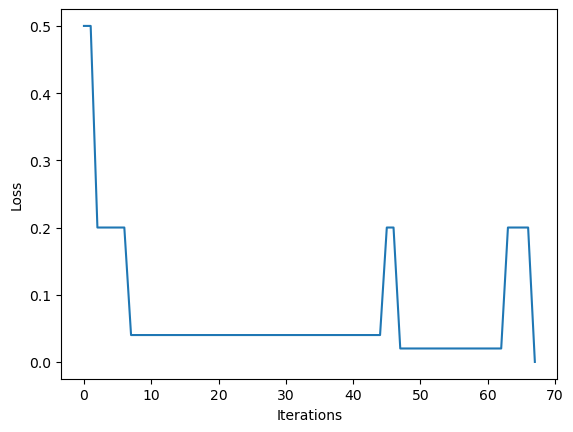

In [7]:
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

And it took 70 iterations to converge. A little unlucky given that there are only 50 data points.
## Experiment 2
In this second experiment, I will show that when the data is not linearly separable, the perceptron algorithm will continue iterating until it reaches a provided maximum number of iterations (for example, through a for loop). It will never reach 0, as this isn't possible for data that isn't linearly separable, and, as such, will continue iterating until told to stop.

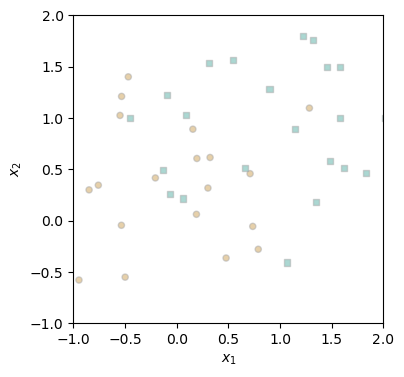

In [8]:
X, y = perceptron_data(n_points = 50, noise = 0.75)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, [0, 0, 0], ax)

Alright - we increased the noise to get some good data here. We can see visually that the data is not linearly separable, so it should serve for this experiment.

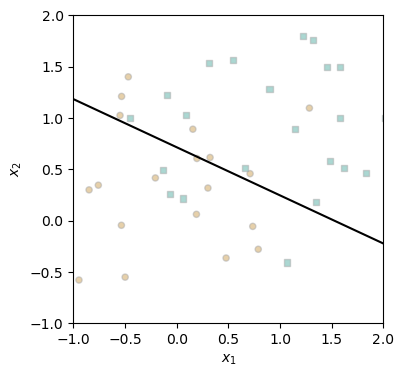

In [9]:
# instantiate a model and an optimizer
p = Perceptron() 
p.w = torch.Tensor([1, 1, 1])
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

for i in range(1000):
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, p.w, ax)

The algorithm did a pretty good job separating most of the points, but as expected, there are some outliers of each group on the wrong side of w.

Text(0, 0.5, 'Loss')

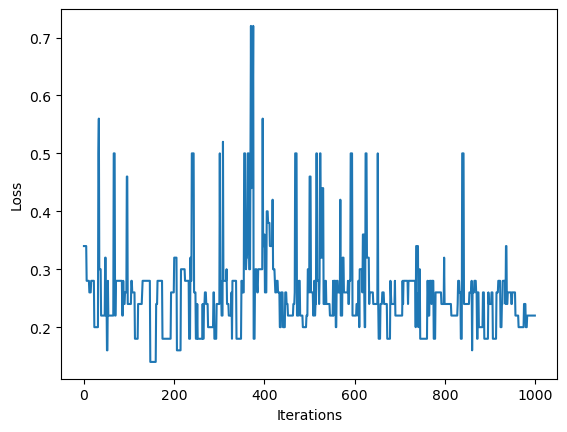

In [10]:
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

As can be seen from the plot of the loss, it was successfully shown that convergence will not occur, and instead the algorithm will continue to iterate until it hits the maximum value of iterations.
## Experiment 3
In this experiment, I will explore how the perceptron performs on high dimension data sets.

Text(0, 0.5, 'Loss')

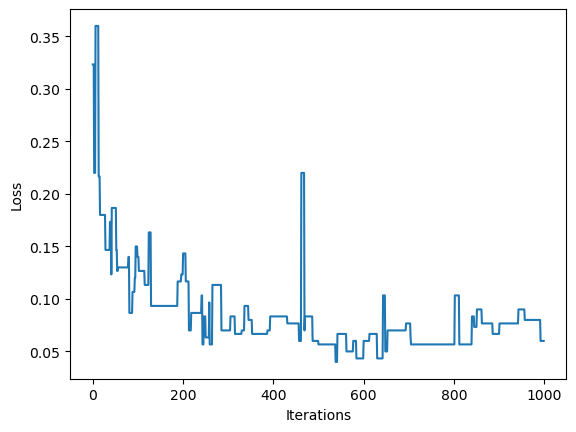

In [11]:
X, y = perceptron_data(n_points = 300, noise = 0.9, p_dims=10)

# instantiate a model and an optimizer
p = Perceptron() 
p.w = torch.rand(X.size()[1])
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

for i in range(1000):
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

My guess would be that this data isn't linearly separable due to the lack of convergence. The plot aligns more closely with that of the second experiment. However, I was interested to observe that the loss seemed to fluctuate a lot less with higher dimensions.

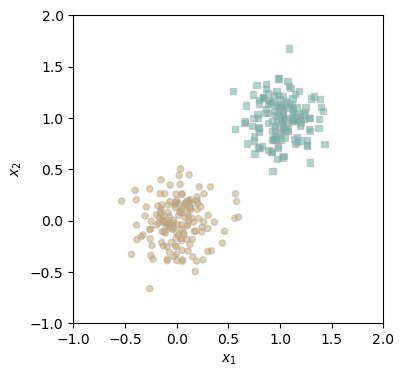

In [23]:
X, y = perceptron_data()
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, [0, 0, 0], ax)

Got some more linearly separable data to test the minibatch perceptron on.

Text(0, 0.5, 'Loss')

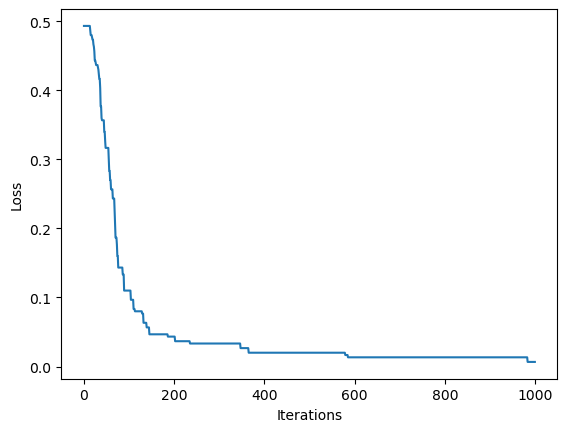

In [24]:
# instantiate a model and an optimizer with a k of 1
p = PerceptronMini() 
p.w = torch.rand(X.size()[1])
opt = PerceptronOptimizerMini(p, k = 1)

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

for i in range(1000):
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i, alpha = 0.01)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

As expected, with k = 1, PerceptronMini still performs pretty similarly to perceptron without the mini batch modification - that is, on linearly separable data, the loss decreases until it eventually reaches 0. Now lets confirm that it can still converge when k is larger, say 10.

Text(0, 0.5, 'Loss')

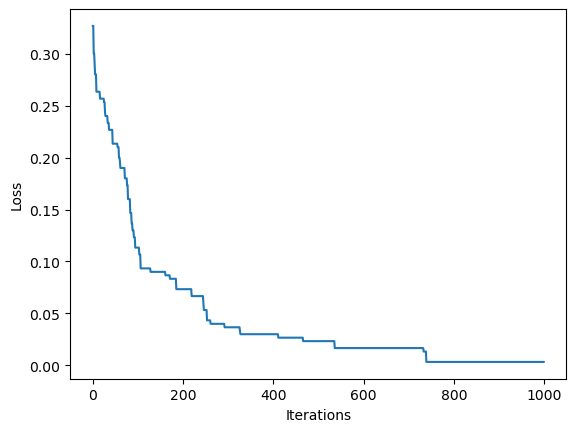

In [25]:
# instantiate a model and an optimizer with a k of 10
p = PerceptronMini() 
p.w = torch.rand(X.size()[1])
opt = PerceptronOptimizerMini(p, k = 10)

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

for i in range(1000):
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i, alpha = 0.01)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Looks good! Not only did it converge, but it converged faster!.

Finally, lets see what happens when k is equal to the entire batch size.

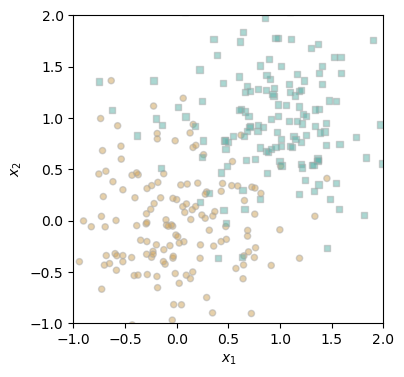

In [33]:
X, y = perceptron_data(noise = 0.5)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, [0, 0, 0], ax)

Text(0, 0.5, 'Loss')

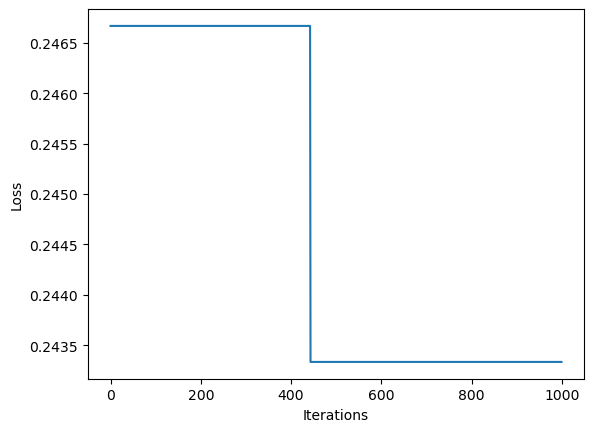

In [34]:
# instantiate a model and an optimizer with a k of 1
p = PerceptronMini() 
p.w = torch.rand(X.size()[1])
opt = PerceptronOptimizerMini(p, k = X.size()[0])

loss = 1.0

# for keeping track of loss values
losses = []

n = X.size()[0]

for i in range(1000):
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    losses.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i, alpha = 0.0001)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Would you look at that! Perceptron can still converge even when the data is not linearly separable (at least with minibatch implemented). It's pretty interesting that it happens all in one move, although maybe this makes sense because k is equal to the batch size.

In terms of implementing the Perceptron class, the gradient function, Perceptron.grad, is incredibly important. It first computes the scores for the input data X, and then calculates exp, an expression to indicate for which instances the model made incorrect predictions. Finally, it calculates the gradient of the loss function, multiplying by X and y to decide which direction the weights must be updated to improve. Finally, it returns the mean of the gradient over the 0th dimension. The runtime complexity of a single iteration of the perceptron algorithm is O(p) where p is the number of features. This comes from the gradient function. Following this time complexity, it seems that the runtime of perceptron relies on the number of features p, but not the number of data points n.

In this blog post, I explored the perceptron algorithm to separate data. One important note about this algorithm is that if the data is not linearly separable, it will never converge. This means it is important to put a cap on the number of times it is run if you aren't sure the data is linearly separable. But the cool thing is, if you implement minibatches, it can still converge (just not to 0, so you should probably still use a for loop and set a maximum number of iterations)! Although this is a pretty simple machine learning model, it was a lot of fun to come back and complete this blog post after completing some of the more complex ones as a comparison. It was still super effective in its own way.